# Indicateur tourisme Côte d'Azur

1ère méthode :  
Essayer de prédire les données officielles à partir des données officielles passées uniquement.  
(pour essayer de mieux comprendre l'étude des séries temporelles)

In [63]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Réduction des données officielles à la Côte d'Azur

In [3]:
#Importe données groupées par mois
df_France_Official_Data2 = pd.read_csv("df_France_Official_Data_month.csv", index_col=0)
df_France_Official_Data2['date'] = pd.to_datetime(df_France_Official_Data2['date'])

In [10]:
#Données Côte d'Azur
df_Official_Data_Sud = df_France_Official_Data2[(df_France_Official_Data2['department']=='Bouches-du-Rhône') 
                                               | (df_France_Official_Data2['department']=='Alpes-Maritimes')
                                               | (df_France_Official_Data2['department']=='Var')]
df_Official_Data_Sud.head(5)

,date,department,value_in_thousands
3,2011-01-01,Alpes-Maritimes,170.80
12,2011-01-01,Bouches-du-Rhône,153.08
89,2011-01-01,Var,62.69
99,2011-02-01,Alpes-Maritimes,205.43
108,2011-02-01,Bouches-du-Rhône,156.19


In [12]:
#On regroupe par mois
df_Official_Data_Sud2 = df_Official_Data_Sud.groupby('date').sum() 
df_Official_Data_Sud2.head(5)

,value_in_thousands
date,
2011-01-01,386.57
2011-02-01,434.73
2011-03-01,572.64
2011-04-01,738.92
2011-05-01,828.78


## Représentation de la série

<AxesSubplot:xlabel='date'>

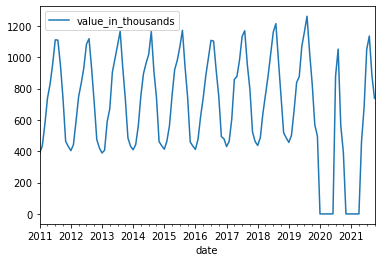

In [15]:
df_Official_Data_Sud2.plot()

/!\ Il y a bcp de valeurs à 0 en 2020 et 2021 avec le covid.

## Stationnarité

La stationnarité signifie que les statistiques de la série temporelle ne dépendent pas du temps. En particulier cela veut dire que il n’y a pas de tendance générale et que les variations apparaissent comme d’amplitude constante. 

  
  
Il y a deux façons principales de déterminer si une série temporelle donnée est stationnaire:

Statistiques roulantes : Tracer la moyenne mobile et l’écart-type mobile. La série temporelle est stationnaire si elle reste constante dans le temps (à l’œil nu, regardez si les lignes sont droites et parallèles à l’axe des x)  
Test de Dickey-Fuller augmenté (ADF) : La série temporelle est considérée comme stationnaire si la valeur p est faible (selon l’hypothèse nulle) et si les valeurs critiques à des intervalles de confiance de 1%, 5%, 10% sont aussi proches que possible des statistiques de l’ADF (Augmented Dickey-Fuller)

### Méthode 1 : moyenne mobile sur 6 mois et écart-type mobile sur 6 mois

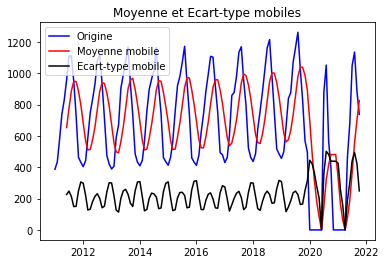

In [17]:
#Méthode 1 : moyenne mobile sur 6 mois et écart-type mobile sur 6 mois

rolling_mean = df_Official_Data_Sud2.rolling(window = 6).mean()
rolling_std = df_Official_Data_Sud2.rolling(window = 6).std()
plt.plot(df_Official_Data_Sud2, color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
plt.legend(loc = 'best')
plt.title('Moyenne et Ecart-type mobiles')
plt.show()

### Méthode 2 : Test ADF

In [18]:
#Methode 2 : Test ADF

result = adfuller(df_Official_Data_Sud2['value_in_thousands'])
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : -1.9321331215071011
p-value : 0.31709889423464693
Valeurs Critiques :
	1%: -3.487517288664615
	5%: -2.8865777180380032
	10%: -2.5801239192052012


La statistique ADF est loin des valeurs critiques et la p-value est supérieure à 0,05. Donc la série temporelle n’est pas stationnaire.

### On stationnarise la série

Prendre le logarithme de la variable dépendante est un moyen simple de réduire le taux d’augmentation de la moyenne mobile.

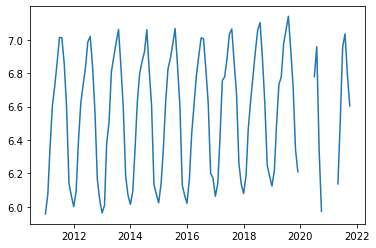

In [55]:
df_Official_Data_Sud2_log = np.log(df_Official_Data_Sud2)
plt.plot(df_Official_Data_Sud2_log)

The most common and convenient method to stationarize the series is by differencing the series at least once until it becomes approximately stationary. So what is differencing? If Y_t is the value at time ‘t’, then the first difference of Y = Yt – Yt-1. 

In [56]:
#Différenciation de premier ordre
df_Official_Data_Sud2_log_diff = df_Official_Data_Sud2_log - df_Official_Data_Sud2_log.shift()
df_Official_Data_Sud2_log_diff

,value_in_thousands
date,
2011-01-01,NaN
2011-02-01,0.117412
2011-03-01,0.275532
2011-04-01,0.254932
2011-05-01,0.114765
...,...
2021-06-01,0.387870
2021-07-01,0.430999
2021-08-01,0.078849


In [45]:
df_Official_Data_Sud2_log_diff[df_Official_Data_Sud2_log_diff['value_in_thousands']==np.inf]

,value_in_thousands
date,
2020-07-01,inf
2021-05-01,inf


In [57]:
#On supprime les valeurs infinies et les NA qui empêchent de faire le test ADF
df_Official_Data_Sud2_log_diff.replace([np.inf, -np.inf], np.nan, inplace=True)
df_Official_Data_Sud2_log_diff.dropna(inplace=True)

In [58]:
#Test ADF

result = adfuller(df_Official_Data_Sud2_log_diff['value_in_thousands'])
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : 0.5394980580007669
p-value : 0.9860254320591114
Valeurs Critiques :
	1%: -3.4968181663902103
	5%: -2.8906107514600103
	10%: -2.5822770483285953


La p-value est pire, la série est encore moins stationnaire.

## Décomposition

La décomposition d’une série temporelle consiste à séparer sa série initiale en plusieurs sous-séries plus simples, chacune représentant un aspect essentiel de la série initiale. Une décomposition typique est la décomposition en 3 séries: tendance, périodique et reste. On retrouve la série originale si on somme les 3 séries composantes.

Dans le graphe ci-dessous on sépare les composantes de tendance, périodique, et le reste avant de les afficher. Notez que l’on applique la décomposition à la série dont la variance a été stabilisée, afin d’avoir une composante périodique qui reste stable dans le temps. Pour l’affichage, on inverse la transformation logarithmique (avec la fonction ‘exp’) pour avoir les données dans l’unité originale.

In [59]:
#On supprime les valeurs manquantes et infinies pour que ça marche
df_Official_Data_Sud2_log.replace([np.inf, -np.inf], np.nan, inplace=True)
df_Official_Data_Sud2_log.dropna(inplace=True)

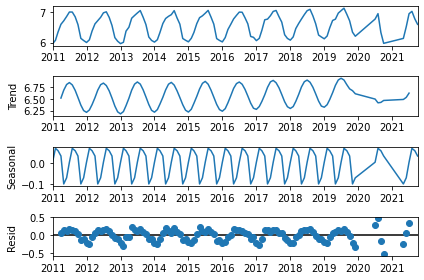

In [61]:
decompose = seasonal_decompose(df_Official_Data_Sud2_log, period=6) #je ne sais pas quelle valeur mettre à period
decompose.plot()
plt.show()

Intérêt ??

## Fonction d'auto-corrélation (ACF) et d'auto-corrélation partielle (PACF)

Trois entiers (p, d, q) sont généralement utilisés pour paramétrer les modèles ARIMA :  
p : nombre de termes autorégressifs (ordre AR)  
d : nombre de différences non saisonnières (ordre de différenciation)  
q : nombre de termes moyens mobiles (ordre MA)  

Nous pouvons utiliser l’ACF pour déterminer le nombre optimal de termes MA. Nous pouvons utiliser le PACF pour déterminer le nombre optimal de termes à utiliser dans le modèle AR. 

C:\Users\Clemence\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


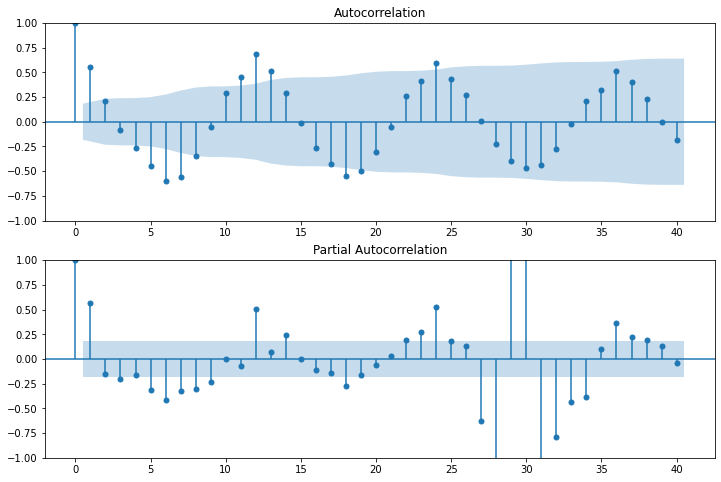

In [64]:
#sur la série différenciée et en log

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_Official_Data_Sud2_log_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_Official_Data_Sud2_log_diff, lags=40, ax=ax2); #comment on choisit lag= ?

Quelle valeur prendre ? 
Pourquoi y a des pb sur la PACF ? --> à cause des valeurs qui ont été supprimées car =inf peut-être ?

ACF : utiliser les 13 mois précédents dans l'équation de la moyenne mobile.  
PACF : utiliser les 36 mois précédents dans l'équation d'auto-régression. ????????????

## Modèle ARIMA

On crée et ajuste un modèle ARIMA avec un AR d’ordre 36, une différence d’ordre 1 et un MA d’ordre 24.

In [71]:
decomposition = seasonal_decompose(df_Official_Data_Sud2_log, period=6) #period=??? 
model = ARIMA(df_Official_Data_Sud2_log, order=(36,1,13)) #(p,d,q)
results = model.fit(disp=-1)
plt.plot(df_Official_Data_Sud2_log_diff)
plt.plot(results.fittedvalues, color='red')

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


Étant donné que nous disposons de données pour chaque mois remontant à 10 ans et que nous voulons prévoir le nombre de touristes sur la Côte d'Azur pour les 10 prochaines années, nous utilisons (12 x 10) + (12 x 10) = 240.

In [72]:
fig = results.plot_predict(1,240)

NameError: name 'results' is not defined